In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import linregress
from Higgs.tools.ImplementationUtils import readHEPDataCsv, implementChannelWidthLimit
import Higgs.bounds as HB
from Higgs.tools.LimitValidation import validateChannelWidthLimit
import Higgs.predictions as HP


def toFittedFun(coeffs):
    return lambda m: coeffs[0] + coeffs[1] * (m - 225.0) + coeffs[2] * np.log(m)


## ATLAS `H+gam>bb` 80fb-1 [1901.10917](https://arxiv.org/abs/1901.10917)

The implementation is from [2103.07484](https://arxiv.org/abs/2103.07484). The full implementation of the inclusive category is in the `jj` folder.

### 1. Mass shift

Since it only depends on the final state, and we only have one final state, this is simple. The parametrization in the paper is overly complicated, a simple linear function over the whole range is enough.

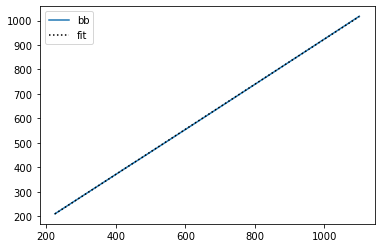

In [2]:
singlePhotonShiftedMass = [220.9499460459883, 0.9266918231874117, -2.069497910863455]
combTriggerShiftedMass = [267.9237702016445, 0.9388069130521747, -10.263128783184035]

singlePhotonRange = np.linspace(225, 450)
combTriggerRange = np.linspace(450, 1100)
totalRange = np.concatenate([singlePhotonRange, combTriggerRange])


shiftedMassDisc = np.concatenate(
    [
        toFittedFun(singlePhotonShiftedMass)(singlePhotonRange),
        toFittedFun(combTriggerShiftedMass)(combTriggerRange),
    ]
)

fit = linregress(
    totalRange,
    shiftedMassDisc,
)

plt.figure()
plt.plot(totalRange, shiftedMassDisc, label="bb")
plt.plot(totalRange, fit.slope * totalRange + fit.intercept, c="k", label="fit", ls=":")
plt.legend()
plt.show()

def toGaussianMass(particleMass):
    return fit.slope * particleMass + fit.intercept


def toParticleMass(gaussianMass):
    return (gaussianMass - fit.intercept) / fit.slope


singlePhotonRange = np.linspace(toParticleMass(225), toParticleMass(449.9))
combTriggerRange = np.linspace(toParticleMass(450), toParticleMass(1050))
totalRange = np.concatenate([singlePhotonRange, combTriggerRange])


### 2. Acceptances

Compared to the inclusive category, we only need neutral production modes, and only care about the `bb` final state. This means we disregard the possibility of fake b-jets.

Text(0.5, 0.98, 'final selection')

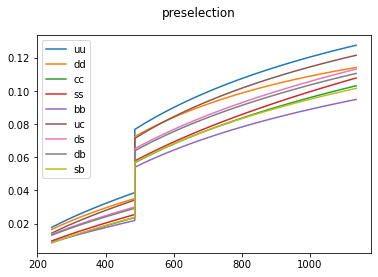

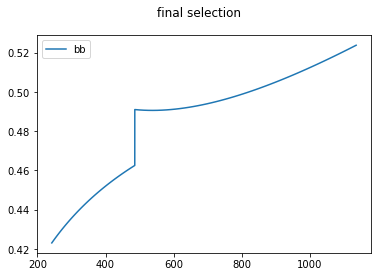

In [3]:
singlePhotonPreselection = {
    "uu": [-0.07453818172065914e0, 3.824816674227349e-05, 0.016692363267610276e0],
    "dd": [-0.08365502599272057e0, 2.472432083149923e-05, 0.018160770096650507e0],
    "cc": [-0.03036038738244472e0, 4.221832611704063e-05, 0.006949082950767061e0],
    "ss": [-0.04243315863987981e0, 3.866314211122518e-05, 0.009348295231225559e0],
    "bb": [-0.02914949139483562e0, 3.419393921510185e-05, 0.006807103486670389e0],
    "uc": [-0.0689894294152424e0, 3.8902627867545764e-05, 0.015043024297551865e0],
    "ds": [-0.0453815009102044e0, 3.744108513321609e-05, 0.010614770882040572e0],
    "db": [-0.048765522647684335e0, 3.456462028873385e-05, 0.01114951745281092e0],
    "sb": [-0.04967090498121169e0, 3.350800124436956e-05, 0.010467748237181393e0],
}

singlePhotonFinalSelection = [
    0.14312123365961413,
    -3.5483692688954893e-05,
    0.060523486229233724,
]

singlePhotonBTagging = [
    0.7349093272718935,
    -3.918931699816906e-06,
    0.028483738485628442,
]

combTriggerPreselection = {
    "uu": [-0.3495397605469713e0, -1.2642459929452903e-05, 0.06945421537488733e0],
    "dd": [-0.3471775210703532e0, -2.5919492355969983e-05, 0.06893383402208757e0],
    "cc": [-0.25771965185274837e0, 5.2868594897241616e-06, 0.05060836725764018e0],
    "ss": [-0.2161349881915616e0, 2.0265589959806386e-05, 0.04342174072764107e0],
    "bb": [-0.2613043396316116e0, -3.894324500526707e-06, 0.051132326713863516e0],
    "uc": [-0.3485345843201749e0, -1.223497402338667e-05, 0.06839930939545714e0],
    "ds": [-0.25385483138026416e0, 6.894729090512683e-06, 0.05128069341398131e0],
    "db": [-0.2726412110713955e0, 7.846779718611548e-07, 0.054373087775165e0],
    "sb": [-0.2784463150279004e0, -2.3232981890858514e-06, 0.054315795840985275e0],
}

combTriggerFinalSelection = [
    1.4594279432344206,
    2.497796055038875e-4,
    -0.15908339475374172,
]

combTriggerBTagging = [0.301508632706373, -1.1289893741976084e-4, 0.10288525863298086]

preselectionDisc = {
    k: np.concatenate(
        [
            toFittedFun(singlePhotonPreselection[k])(singlePhotonRange),
            toFittedFun(combTriggerPreselection[k])(combTriggerRange),
        ]
    )
    for k in singlePhotonPreselection.keys()
}
finalSelectionDisc = np.concatenate(
    [
        toFittedFun(singlePhotonFinalSelection)(singlePhotonRange)
        * toFittedFun(singlePhotonBTagging)(singlePhotonRange),
        toFittedFun(combTriggerFinalSelection)(combTriggerRange)
        * toFittedFun(combTriggerBTagging)(combTriggerRange),
    ]
)


fig, ax = plt.subplots()
for k, v in preselectionDisc.items():
    ax.plot(totalRange, v, label=k)
ax.legend()
fig.suptitle("preselection")

fig, ax = plt.subplots()
ax.plot(totalRange, finalSelectionDisc, label="bb")
ax.legend()
fig.suptitle("final selection")


### 3. compute the combined acceptances for every IS


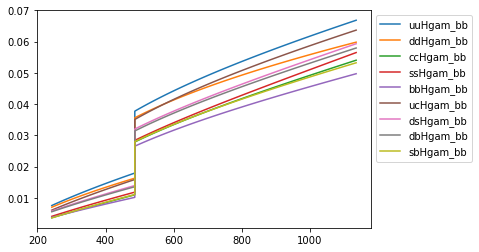

In [4]:
combinedNeutralAcceptances = {
    f"{p}Hgam_bb": accP * finalSelectionDisc for p, accP in preselectionDisc.items()
}
fig, ax = plt.subplots()
for k, v in combinedNeutralAcceptances.items():
    ax.plot(totalRange, v, label=k)
ax.legend(bbox_to_anchor=(1, 1))

### 4. Implement the Limit

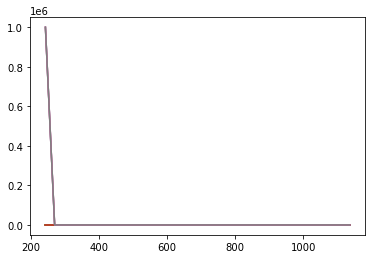

Looks good. Saving this to Hgam_LHC13_ATLAS_80.json


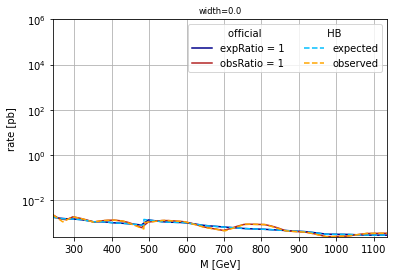

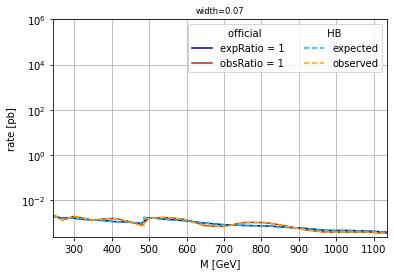

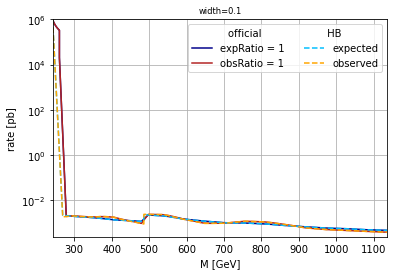

In [5]:
def readTable(i):
    dfs = readHEPDataCsv(
        f"https://www.hepdata.net/download/table/ins1717700/Table%{i}/1/csv",
        na_values="empty",
    )

    for df in dfs:
        if df.columns[1].startswith("Detector resolution"):
            df["normWidth"] = 0
        else:
            df["normWidth"] = float(df.columns[1][-4:])

    def renames(name):
        if name == "$m(G) [GeV]$":
            return "mG"
        elif "obs" in name:
            return "obs"
        elif "exp" in name:
            return "exp"
        return name

    dfs = [df.rename(columns=renames) for df in dfs]
    return pd.merge(
        pd.concat([df for df in dfs if "obs" in df.columns]),
        pd.concat([df for df in dfs if "exp" in df.columns]),
        on=["mG", "normWidth"],
    ).fillna(1e6)


dfSinglePhoton = readTable(207)
dfSinglePhoton.loc[dfSinglePhoton.mG == 450, "mG"] = 449.9
dfCombinedTrigger = readTable(208)
df = pd.concat([dfSinglePhoton, dfCombinedTrigger])
df["m"] = toParticleMass(df.mG)


from scipy.interpolate import interp1d

acceptanceGrid = [
    toParticleMass(225),
    350,
    toParticleMass(449.9),
    toParticleMass(450),
    600,
    800,
    1000,
    toParticleMass(1050),
]

acceptanceFuncs = {
    k: interp1d(totalRange, v) for k, v in combinedNeutralAcceptances.items()
}
acceptanceData = {k: f(acceptanceGrid) for k, f in acceptanceFuncs.items()}


process = {"channels": [x.split("_") for x in acceptanceData.keys()]}
acceptances = [
    {"massDepAcceptance": v, "massGrid": acceptanceGrid}
    for v in acceptanceData.values()
]

limitFile = implementChannelWidthLimit(
    "1901.10917",
    process,
    "https://doi.org/10.17182/hepdata.85763 & 2103.07484",
    df,
    massResolution={"absolute": 0, "relative": 5e-2},  # 3-8% on page 7
    acceptances=acceptances,
    idSuffix=2,
    prefix="Hgam",
)

lim = HB.Limit(limitFile)


def accountForEfficiencies(h, rate):
    for p, d in process["channels"]:
        prevRate = h.channelRate(lim.collider(), p, d)
        if prevRate > 0:
            h.setChannelRate(
                lim.collider(),
                p,
                d,
                h.channelRate(lim.collider(), p, d)
                / acceptanceFuncs["_".join([p, d])](h.mass()),
            )


validateChannelWidthLimit(
    lim, setAdditionalRates=accountForEfficiencies, descInTitle=False
)
